Bayesian optimization with k-nearest neighbors(KNN) regressors

Bayesian optimization with Gaussian process regression

A hallmark of Bayesian inference is the simultaneous presentation of estimates and uncertainty.

multi-dimension examples

Important assumptions:
* The function takes a long time to compute, or the function contains noise.
* It is difficult to obtain the derivative for the function.
* The data size to be trained is large.
* For clarity in the discussion, all the tasks aim for function minimization.

We are using the assumption that training many regression models from data and using the trained models are much cheaper than the actual measurements. Therefore, when using trained models, a fairly free general optimization process is performed. Of course, these are the predictions (with deviations) that the currently built models suggest. It is not the actual value, in general. The goal is to get the true value (real measurement) with the help of these models. In this calculation, it is important to note that the calculations involving models have a computational complexity that depends linearly on the size of the data, *O(n)*.


Moreover, we use the Hassanat distance metric that is invariant to data scale, noise and outliers.
https://arxiv.org/pdf/1409.0923

In [1]:
from scipy.stats import norm
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.optimize import dual_annealing
import time
import random


class Info:
    lknn = True
    ndim = 1
    beta = 2.
    niterations = 100
    nsamples0 = 10
    icase = 1
    model12 = False
    model = None
    lw = None
    up = None
    hassanat = False


def hassanat_dist_metric(x1, x2):
    tmp = 0.
    for i in range(len(x1)):
        min_ = min(x1[i], x2[i])
        max_ = max(x1[i], x2[i])
        if min_ >= 0:
            di = 1-(1+min_)/(1+max_)
        else:
            di = 1-(1+min_ + np.abs(min_))/(1+max_+np.abs(min_))
        tmp = tmp+di
    return tmp


def hassanat_dist_metric1(x1, x2):
    tmp = 0.
    for i in range(len(x1)):
        min_ = min(x1[i], x2[i])
        max_ = max(x1[i], x2[i])
        if min_ >= 0:
            di = 1-(1+min_)/(1+max_)
        else:
            di = 1-1/(1+max_+np.abs(min_))
        tmp = tmp+di
    return tmp


def hassanat_dist_metric2(x1, x2):
    tmp = 1.
    for i in range(len(x1)):
        min_ = min(x1[i], x2[i])
        max_ = max(x1[i], x2[i])
        if min_ >= 0:
            di = 1-np.abs(x1[i]-x2[i])/(1+max_)
        else:
            di = 1-np.abs(x1[i]-x2[i])/(1+max_+np.abs(min_))
        tmp = tmp-di
    return tmp


def bent_cigar(x):
    return x[0]**2 + 1e6*sum([v**2 for v in x[1:]])


def brown(x):
    return sum([
        ((x[i]**2)**(x[i+1]**2 + 1.0)) +
        ((x[i+1]**2)**(x[i]+1.0))
        for i in range(len(x)-1)])


def cosine_mixture(x):
    return 0.1 * sum([np.cos(5*np.pi*v) for v in x]) - sum([v**2 for v in x])


def csendes(x):
    return sum([v**6 * (2+np.sin(safe_div(1, v))) for v in x])


def dixon_price(x):
    return (x[0] - 1.0)**2.0 + sum([i*(2.0*x[i]**2.0 - x[i-1])**2.0 for i in range(1, len(x))])


def griewank(xy):
    a, b, = 0, 1
    for i, v in enumerate(xy):
        a += v**2 / 4000.0
        b *= np.cos(v/np.sqrt(i+1))
    return a - b + 1


def michalewicz(x, m=10):
    d = len(x)
    result = 0
    for i in range(d):
        result -= np.sin(x[i])*(np.sin((i+1)*x[i]**2/np.pi))**(2*m)
    return result


def afun(xvector):
    icase = Info.icase

    if icase == 1 and len(xvector) == 2:
        tmp = np.sin(xvector[0]+xvector[1])+(xvector[0] -
                                             xvector[1])**2-1.5*xvector[0]+2.5*xvector[1] + 1
    if icase == 2 and len(xvector) == 2:
        tmp = -20.*np.exp(-0.2*np.sqrt(0.5*(xvector[0]**2+xvector[1]**2)))-np.exp(0.5 *
                                                                                  (np.cos(np.pi*2*xvector[0])+np.cos(np.pi*2*xvector[1])))+np.exp(1.)+20.
    if icase == 3 and len(xvector) == 2:
        tmp = (1.+(xvector[0]+xvector[1]+1)**2 * (19.-14*xvector[0]+3.*xvector[0]**2-14*xvector[1] + 6*xvector[0]*xvector[1]+3*xvector[1]**2)) * \
            (30.+(2*xvector[0]-3*xvector[1])**2 * (18-32*xvector[0]+12*xvector[0]
             ** 2 + 48*xvector[1] - 36*xvector[0]*xvector[1] + 27*xvector[1]**2))
    if icase == 4 and len(xvector) == 2:
        tmp = (xvector[0]**2 + xvector[1]-11)**2 + \
            (xvector[0]+xvector[1]**2-7)**2
    if icase == 5 and len(xvector) == 2:
        tmp = (xvector[0]**4 - 16*xvector[0]**2 + 5*xvector[0] +
               xvector[1]**4 - 16*xvector[1]**2 + 5*xvector[1])/2.
    if icase == 6 and len(xvector) > 0:
        tmp = bent_cigar(xvector)
    if icase == 7 and len(xvector) > 0:
        tmp = brown(xvector)
    if icase == 8 and len(xvector) > 0:
        tmp = cosine_mixture(xvector)
    if icase == 9 and len(xvector) > 0:
        tmp = csendes(xvector)
    if icase == 10 and len(xvector) > 0:
        tmp = dixon_price(xvector)
    if icase == 11 and len(xvector) > 0:
        tmp = griewank(xvector)
    if icase == 12 and len(xvector) > 0:
        tmp = np.sum(xvector*xvector - 10*np.cos(2*np.pi*xvector)
                     ) + 10*np.size(xvector)
    if icase == 13 and len(xvector) > 0:
        tmp = 0.
        for i in range(len(xvector)-1):
            tmp = tmp + (1.-xvector[i])**2
        for i in range(len(xvector)-1):
            tmp = tmp + 100.*(xvector[i+1]-xvector[i]**2)**2
    if icase == 14:
        tmp = 0.
        for i in range(len(xvector)):
            tmp = tmp + (xvector[i]**4 - 16*xvector[i]**2 + 5*xvector[i])/2.
    return tmp


class GP0():
    def __init__(self):
        if True:
            #    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
            self.kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * \
                RBF(1.0, length_scale_bounds="fixed")
        else:
            self.kernel = DotProduct() + WhiteKernel()
        self.gp = GaussianProcessRegressor(
            kernel=self.kernel, n_restarts_optimizer=0)

    def fit(self, X, y):
        self.gp.fit(X, y)

    def predict(self, X_test):
        y_pred, y_std = self.gp.predict(X_test, return_std=True)
        return y_pred, y_std


class Multi_knn0():
    def __init__(self):
        if Info.hassanat:
            self.knn4 = KNeighborsRegressor(metric=hassanat_dist_metric,
                                            n_neighbors=4, leaf_size=30,  weights='distance')
            self.knn5 = KNeighborsRegressor(metric=hassanat_dist_metric,
                                            n_neighbors=5, leaf_size=30,  weights='distance')
            self.knn6 = KNeighborsRegressor(metric=hassanat_dist_metric,
                                            n_neighbors=6, leaf_size=30,  weights='distance')
            self.knn7 = KNeighborsRegressor(metric=hassanat_dist_metric,
                                            n_neighbors=7, leaf_size=30,  weights='distance')
            self.knn8 = KNeighborsRegressor(metric=hassanat_dist_metric,
                                            n_neighbors=8, leaf_size=30,  weights='distance')
            self.knn9 = KNeighborsRegressor(metric=hassanat_dist_metric,
                                            n_neighbors=9, leaf_size=30,  weights='distance')
        else:
            self.knn4 = KNeighborsRegressor(p=2.,
                                            n_neighbors=4, leaf_size=30,  weights='distance')
            self.knn5 = KNeighborsRegressor(p=2.,
                                            n_neighbors=5, leaf_size=30,  weights='distance')
            self.knn6 = KNeighborsRegressor(p=2.,
                                            n_neighbors=6, leaf_size=30,  weights='distance')
            self.knn7 = KNeighborsRegressor(p=2.,
                                            n_neighbors=7, leaf_size=30,  weights='distance')
            self.knn8 = KNeighborsRegressor(p=2.,
                                            n_neighbors=8, leaf_size=30,  weights='distance')
            self.knn9 = KNeighborsRegressor(p=2.,
                                            n_neighbors=9, leaf_size=30,  weights='distance')
        if Info.model12:
            self.knn41 = KNeighborsRegressor(
                n_neighbors=4, leaf_size=30, p=1.5, weights='distance')
            self.knn51 = KNeighborsRegressor(
                n_neighbors=5, leaf_size=30, p=1.5, weights='distance')
            self.knn61 = KNeighborsRegressor(
                n_neighbors=6, leaf_size=30, p=1.5, weights='distance')
            self.knn71 = KNeighborsRegressor(
                n_neighbors=7, leaf_size=30, p=1.5, weights='distance')
            self.knn81 = KNeighborsRegressor(
                n_neighbors=8, leaf_size=30, p=1.5, weights='distance')
            self.knn91 = KNeighborsRegressor(
                n_neighbors=9, leaf_size=30, p=1.5, weights='distance')

    def fit(self, X, y):
        self.knn4.fit(X, y)
        self.knn5.fit(X, y)
        self.knn6.fit(X, y)
        self.knn7.fit(X, y)
        self.knn8.fit(X, y)
        self.knn9.fit(X, y)
        if Info.model12:
            self.knn41.fit(X, y)
            self.knn51.fit(X, y)
            self.knn61.fit(X, y)
            self.knn71.fit(X, y)
            self.knn81.fit(X, y)
            self.knn91.fit(X, y)

    def predict(self, X_test):
        anarray = []
        ypred = self.knn4.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn5.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn6.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn7.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn8.predict(X_test)
        anarray.append(ypred)
        ypred = self.knn9.predict(X_test)
        anarray.append(ypred)
        if Info.model12:
            ypred = self.knn41.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn51.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn61.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn71.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn81.predict(X_test)
            anarray.append(ypred)
            ypred = self.knn91.predict(X_test)
            anarray.append(ypred)
        anarray = np.array(anarray)
        return np.mean(anarray), np.std(anarray)


def afun_model(x):
    X_test = np.zeros((1, len(x)))
    X_test[0, :] = x[:]
    tmp, tmq = Info.model.predict(X_test)
    tmr = tmp-tmq*Info.beta
    return tmr


def local_afun_model(x):
    ret = dual_annealing(
        afun_model, x0=x, bounds=list(zip(Info.lw, Info.up)), maxiter=250, maxfun=10000, no_local_search=False)
    return ret.x, ret.fun


def driverBOKNN(lw, up):
    start = time.time()
    ndim = Info.ndim
    lknn = Info.lknn
    beta = Info.beta
    niterations = Info.niterations
    nsamples = Info.nsamples0
    best_x = np.zeros(ndim)
    xvector = np.zeros(ndim)
    yvector = np.zeros(ndim)
    zvector = np.zeros(ndim)
    best_y = 1e99
    alist = []
    blist = []
    iprint = 0
    for iitt in range(nsamples):
        if iitt > 0:
            tmp0 = 9e99
            for i0 in range(ndim*100):
                for j in range(ndim):
                    yvector[j] = lw[j]+(up[j]-lw[j])*np.random.random()
                tmp = 0.
                for i in range(len(blist)):
                    for j in range(ndim):
                        zvector[j] = alist[i][j]
                    tmq = hassanat_dist_metric(yvector, zvector)
                    tmp = tmp+1./(tmq+1e-8)
                if tmp0 > tmp:
                    tmp0 = tmp
                    xvector[:] = yvector[:]
        else:
            for j in range(ndim):
                xvector[j] = lw[j]+(up[j]-lw[j])*np.random.random()
        tmp = afun(xvector)
        alist.append([xvector[j] for j in range(ndim)])
        blist.append(tmp)
        astring = ''
        for j in range(ndim):
            astring = astring+' '+str(xvector[j])
        astring = astring+' '+str(tmp)
        if iprint > 2:
            print(iitt, astring)

    if lknn:
        model = Multi_knn0()
    else:
        model = GP0()

    for iitt in range(niterations):
        m = len(blist)
        X = np.zeros((m, ndim))
        y = np.zeros(m)
        for i in range(m):
            for j in range(ndim):
                X[i, j] = alist[i][j]
            y[i] = blist[i]
            if blist[i] < best_y:
                best_y = blist[i]
                for j in range(ndim):
                    best_x[j] = alist[i][j]
        model.fit(X, y)
        del X, y
        Info.model = model
        if True:
            tmp0 = 9e99
            for i0 in range(ndim*100):
                for j in range(ndim):
                    yvector[j] = lw[j]+(up[j]-lw[j])*np.random.random()
                tmp = 0.
                for i in range(len(blist)):
                    for j in range(ndim):
                        zvector[j] = alist[i][j]
                    tmq = hassanat_dist_metric(yvector, zvector)
                    tmp = tmp+1./(tmq+1e-8)
                if tmp0 > tmp:
                    tmp0 = tmp
                    xvector[:] = yvector[:]
        xvector, tmp1 = local_afun_model(xvector)
        if True:
            sitoldist = 1e-2
            for i in range(len(blist)):
                for j in range(ndim):
                    zvector[j] = alist[i][j]
                jjtt = 0
                while hassanat_dist_metric(xvector, zvector) < sitoldist:
                    jjtt = jjtt+1
                    jlist = [j for j in range(ndim)]
                    random.shuffle(jlist)
                    for j0 in range(int(ndim/2)):
                        j = jlist[j0]
                        xvector[j] = xvector[j] + \
                            (np.random.random()-0.5)*(up[j]-lw[j])*2e-1
                        if xvector[j] < lw[j] or xvector[j] > up[j]:
                            xvector[j] = lw[j] + \
                                (up[j]-lw[j])*np.random.random()
                if jjtt > 0:
                    break
        tmp = afun(xvector)
        alist.append([xvector[j] for j in range(ndim)])
        blist.append(tmp)
        astring = ''
        for j in range(ndim):
            astring = astring+' '+str(xvector[j])
        astring = astring+'  '+str(tmp)
        if iprint > 2:
            print(len(blist)-1, astring, tmp1)
        if blist[-1] < best_y:
            best_y = blist[-1]
            for j in range(ndim):
                best_x[j] = alist[-1][j]
            if iprint == 0:
                print(len(blist)-1, astring, tmp1)
    end = time.time()
    print(end - start, (end-start)/60., 'min')

    plt.rcParams["xtick.minor.visible"] = True
    plt.rcParams["ytick.minor.visible"] = True
    y = [blist[j] for j in range(len(blist))]
    x = []
    for i in range(len(y)):
        x.append(i)
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, linestyle='none', marker='d',
             markersize=5, fillstyle='none')
    plt.xlabel('Number of function calculations', fontsize=18)
    plt.ylabel('Function', fontsize=18)
#    plt.yscale('log')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=18)
    plt.tight_layout()
#   plt.savefig("boknn1.pdf")
    plt.show()
    plt.close()

25  -1.022551542270076 -1.5932407824115515  22.016677148679015 25.760786567310202
34  -1.0225515538588246 -1.9258579708731596  5.920351625161459 22.01667865583344
35  -1.0225515548072552 -1.1359484647607503  5.867911437778009 5.920352166572095
36  -1.0225516009843083 -1.9588255479060273  5.315613585539628 5.867916425202671
40  -1.022551605374002 -0.9394355771866298  2.7437204511799003 5.315614273946271
51  -0.9806137051136894 -0.9927118992275514  2.0316569599496823 2.578478506366887
89  -0.9973437967745736 -0.9828684477683747  2.0199943906673923 2.026216852469491
95  -0.9992867185193096 -1.004645456064236  2.0122463358629403 2.006504831215139
96  -0.9905716565620495 -0.9905485650953809  1.9975882199364534 2.0093516943196756
117  -0.990571661887621 0.004015695557188281  1.0019730361267492 1.9975882631119815
245  0.017947044255412714 0.004015693418953724  0.06703309431838278 1.0019730611508149
273  -0.00010987413194813135 -0.009862914880913693  0.019295255725822358 0.16165079187008957
29

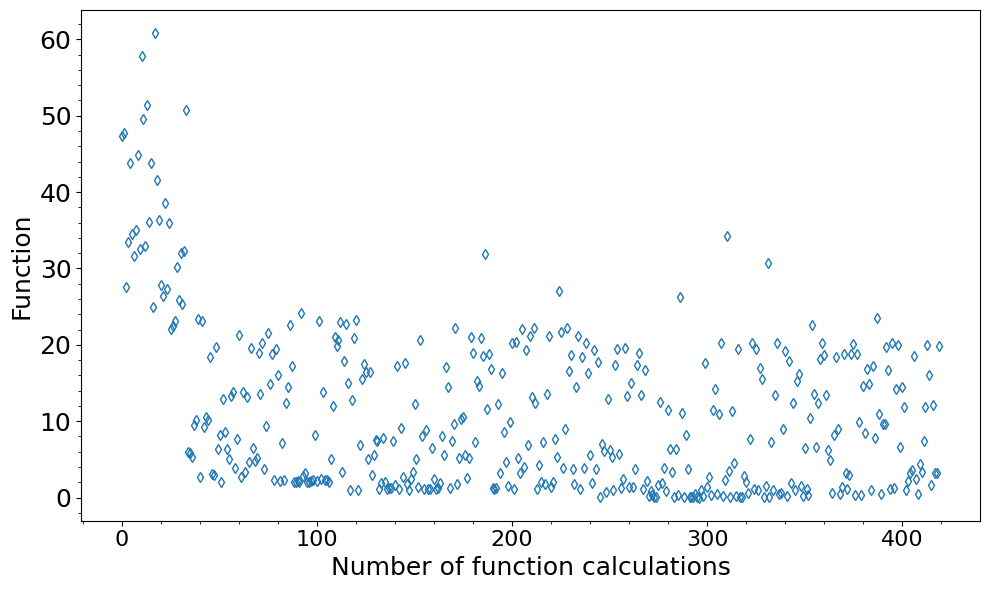

In [2]:
Info.icase = 12
Info.ndim = 2
Info.lknn = True
Info.hassanat = True
Info.model12 = False
Info.beta = 2.
Info.niterations = Info.ndim * 200
Info.nsamples0 = 20
# np.random.seed(17)
if Info.icase == 12:
    lw = [-5.12] * Info.ndim
    up = [5.12] * Info.ndim
if Info.icase == 11:
    lw = [-600.]*Info.ndim
    up = [600.]*Info.ndim
Info.lw = lw
Info.up = up
driverBOKNN(lw, up)

22  0.14973736247854375 4.104709425545739 -1.2272636706329088 0.017343098245382653  33.209217570759996 39.251037963838215
55  -0.014546208133881309 3.850947565854312 -1.0264829414354728 -0.012241665253185003  20.16733595381348 38.652828822684285
99  -0.01810534739678925 4.0596008080138395 -1.0678441757794752 0.0020381047704926877  19.274356605025048 19.67428195902473
108  0.0049286551275282645 3.996737126522023 -1.0180804753963433 0.09750923933326856  18.910119339457978 19.631697731286618
141  -0.01542665043566895 3.997860556466609 -0.9667326551461004 -0.012918091244788854  17.21629324369448 19.298465708051136
184  -2.042685524506722 2.9667670210210657 -1.000309693610546 -0.07378234191224865  15.610538307307877 25.55492048544054
243  -0.04972798132679227 0.07904481107368604 -0.9479210858698696 -0.7615754688044467  12.983560191801779 21.181840293100432
271  -0.06799688652691128 0.018155730604400795 -0.9645493833005014 -0.7936439590695629  10.068091115750988 14.727073066739456
275  -0.06

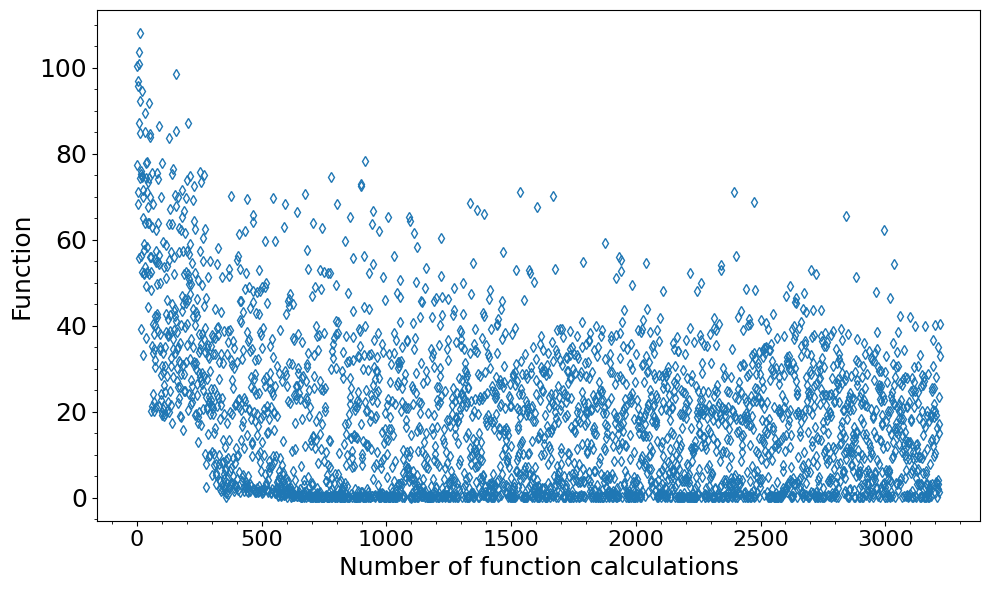

In [3]:
Info.icase = 12
Info.ndim = 4
Info.lknn = True
Info.hassanat = False
Info.model12 = False
Info.beta = 2.
Info.niterations = Info.ndim * 800
Info.nsamples0 = 20
# np.random.seed(17)
if Info.icase == 12:
    lw = [-5.12] * Info.ndim
    up = [5.12] * Info.ndim
if Info.icase == 11:
    lw = [-600.]*Info.ndim
    up = [600.]*Info.ndim
Info.lw = lw
Info.up = up
driverBOKNN(lw, up)

289  0.9979988656453862 -1.9601024786970496 -0.7701682272059035 0.6789359750500114  29.25984707880085 6.372080401157328
345  1.9972892079600557 1.1198798173893736 -1.2301658427177498 -0.7439706580539881  29.152442893618183 10.714408171798581
479  1.6656261127676757 -2.0053429495306023 -0.02121485211029859 1.1040519105205744  25.228027305863765 20.04643301992228
495  -1.8323312885813205 0.8569691949150955 -1.0893286787464649 1.0423986087866963  17.080267926648247 20.01420655874226
569  -2.139134819837097 1.042800087560161 -1.118107145774288 1.032798749122396  14.764566270501454 2.1839178704401974
739  0.06566783044134443 0.010579935696553211 2.0889143688134837 0.8852329314938725  10.022497181474609 12.884471332473806
858  -0.0033463972596004337 -0.007674238814110669 1.909730375409376 0.9670623870212751  6.375378248930005 1.8585566298892713
1093  0.020959516549363084 0.025433472145208576 1.9555252424667802 0.9827569398353737  5.451519593527443 5.9168943478543445
2475  0.04821450159621408

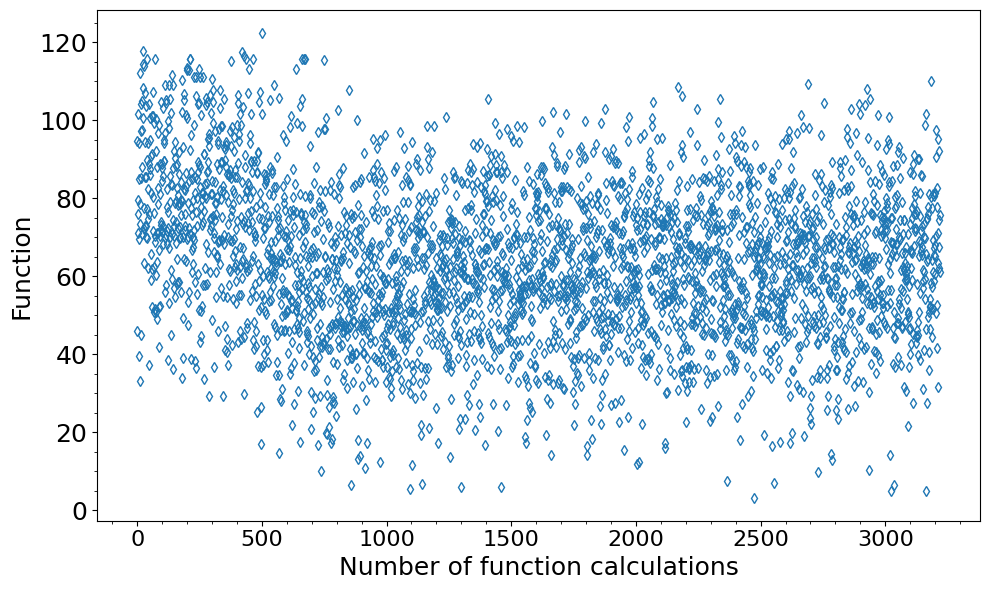

In [4]:
Info.icase = 12
Info.ndim = 4
Info.lknn = False
Info.model12 = False
Info.beta = 2.
Info.niterations = Info.ndim * 800
Info.nsamples0 = 20
# np.random.seed(17)
if Info.icase == 12:
    lw = [-5.12] * Info.ndim
    up = [5.12] * Info.ndim
if Info.icase == 11:
    lw = [-600.]*Info.ndim
    up = [600.]*Info.ndim
Info.lw = lw
Info.up = up
driverBOKNN(lw, up)

20  0.28039596690923274 -0.02097677996071849  1.5098196347512745 -26.756853314796217
39  0.12509762656736712 -0.02611993056780193  0.9399219957516209 -0.9758319302730207
41  0.4308415615857684 0.21062819420143591  0.38646004447800264 -7.227150737129488
105  0.39572493671118864 0.15141628736011645  0.36783360043760555 0.3774853083237589
127  0.40521491270166154 0.16916207489585483  0.35623238676707925 0.3773025935096019
131  0.4844559088400615 0.24210782433551092  0.2712769596858646 0.3040224449084354
133  0.5013322486012451 0.2507351046295416  0.24870539666494185 0.20945246989836297
138  0.5533216867323265 0.29527414937516416  0.21138233651934435 0.11987200388918684
144  0.5792142347209369 0.34836372537579124  0.1936361816343438 0.1528985356302615
145  0.6032190312204289 0.3455232243768792  0.19110729635187124 0.13454182837792658
146  0.6128522088136774 0.37433174568975097  0.1500411869616594 -0.0780241006007022
163  0.6627302252018126 0.44465215183458895  0.11671113193362583 0.1632340

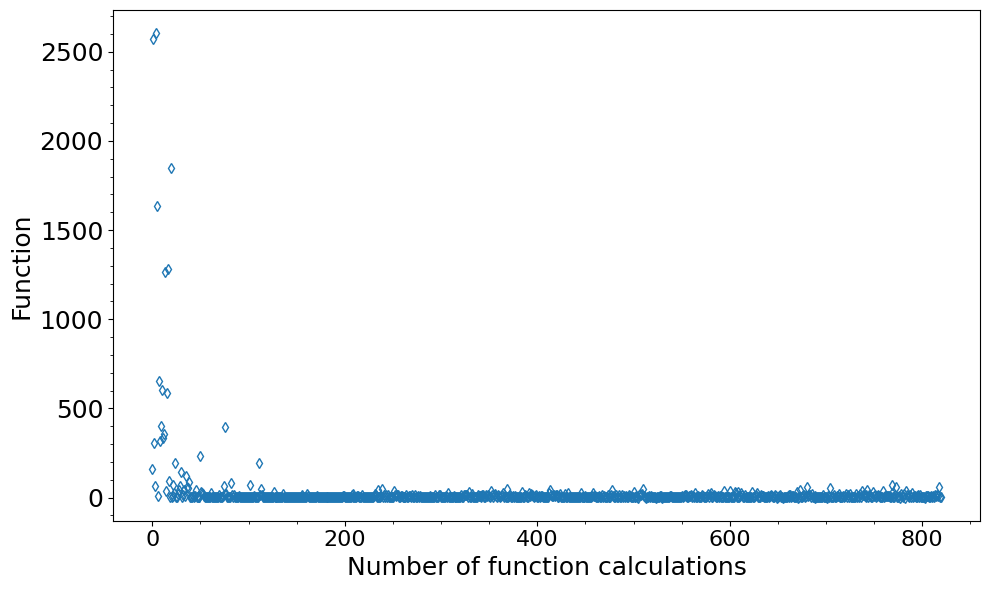

In [5]:
Info.icase = 13
Info.ndim = 2
Info.lknn = True
Info.hassanat = False
Info.model12 = False
Info.beta = 2.
Info.niterations = Info.ndim * 400
Info.nsamples0 = 20
# np.random.seed(17)
lw = [-5.12] * Info.ndim
up = [5.12] * Info.ndim
if Info.icase == 13:
    lw = [-2.]*Info.ndim
    up = [2.]*Info.ndim
if Info.icase == 12:
    lw = [-5.12] * Info.ndim
    up = [5.12] * Info.ndim
if Info.icase == 11:
    lw = [-600.]*Info.ndim
    up = [600.]*Info.ndim
Info.lw = lw
Info.up = up
driverBOKNN(lw, up)

22  -0.4711321642694461 0.2551365580120056  2.2742616461763703 -6.097515695571052
25  1.0724750417357705 1.1825851451851384  0.11011480919764649 -2.5564098118622516
30  1.1507475076098865 1.3017050683385465  0.07341624352343548 -1.40526631330683
31  1.1118422003451167 1.2483810192516054  0.027363267831844645 -0.3685322529295831
35  1.0209255107640909 1.0314772914472388  0.01212696176960367 -0.16288535252609526
41  1.0988738756861354 1.2052382008122706  0.010298437219374715 -0.008052081450178692
42  1.0489425615932375 1.1000109327928458  0.0024026408496165366 0.0014864095627861076
46  0.9986763977773346 0.9991719680155168  0.0003320536640396146 -0.008785201234374825
72  1.0102941103426195 1.0206090224779214  0.00010669404808817208 0.0016003188352316485
367.3623118400574 6.122705197334289 min


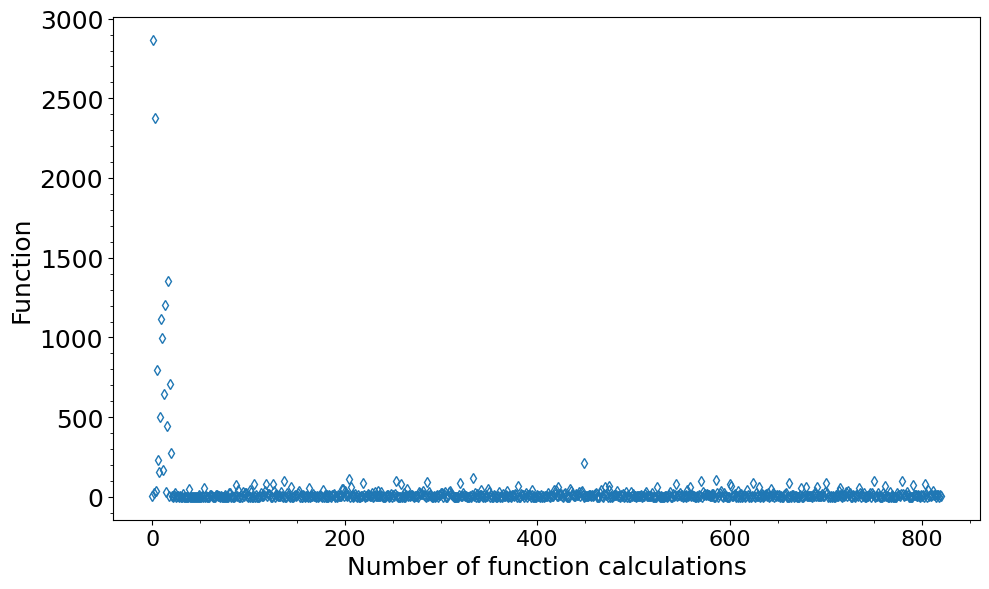

In [6]:
Info.icase = 13
Info.ndim = 2
Info.lknn = False
Info.hassanat = False
Info.model12 = False
Info.beta = 2.
Info.niterations = Info.ndim * 400
Info.nsamples0 = 20
# np.random.seed(17)
lw = [-5.12] * Info.ndim
up = [5.12] * Info.ndim
if Info.icase == 13:
    lw = [-2.]*Info.ndim
    up = [2.]*Info.ndim
if Info.icase == 12:
    lw = [-5.12] * Info.ndim
    up = [5.12] * Info.ndim
if Info.icase == 11:
    lw = [-600.]*Info.ndim
    up = [600.]*Info.ndim
Info.lw = lw
Info.up = up
driverBOKNN(lw, up)

23  -2.7411293247093336 -2.6817422621223175  -77.11233802021808 -68.82064101395515
26  -3.053845863684199 -2.7428870874529805  -77.49916842687539 -77.08628768406278
35  -2.9810970783737494 -2.895040467502104  -78.22433343838702 -77.52820786922655
41  -2.9776974047370715 -2.8880230174647843  -78.23070196272923 -78.22776460393264
43  -2.880897983290491 -2.8587127553961618  -78.28932172785315 -78.28467039534341
55  -2.865514380905663 -2.878978029874076  -78.29731377192337 -78.27463372538878
56  -2.8840384818108036 -2.8789779774225073  -78.3154612832887 -78.2973136707326
64  -2.910690385655184 -2.9142770765090584  -78.32944084316469 -78.30331446501235
85  -2.9120016554911143 -2.9043708995321285  -78.33107595059147 -78.32627689506967
101  -2.9018488856783127 -2.9000738510837354  -78.3320755445903 -78.32921713759787
1872.843177318573 31.21405295530955 min


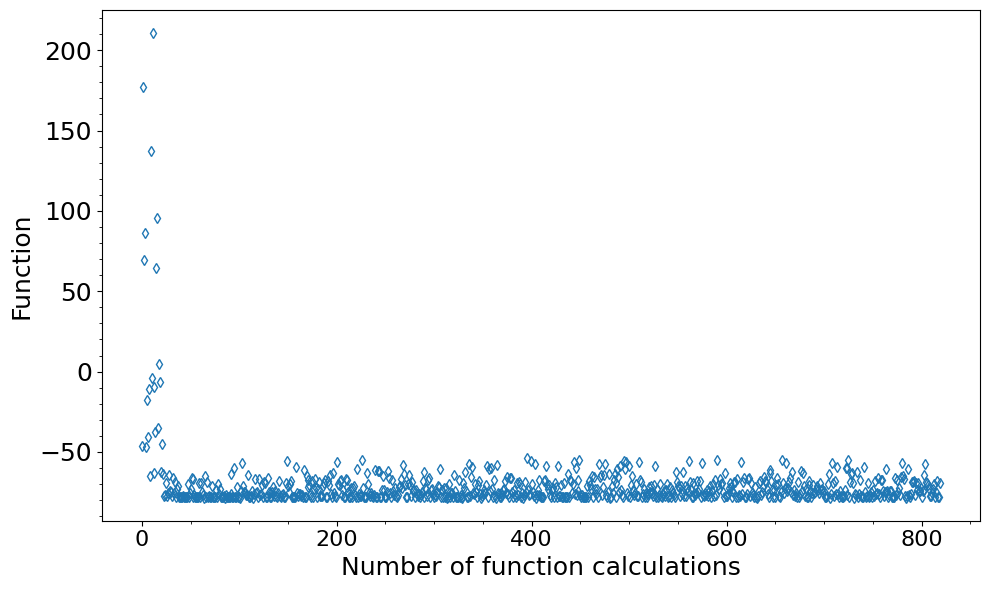

In [7]:
Info.icase = 14
Info.ndim = 2
Info.lknn = True
Info.hassanat = False
Info.model12 = False
Info.beta = 2.
Info.niterations = Info.ndim * 400
Info.nsamples0 = 20
# np.random.seed(17)
if Info.icase == 14:
    lw = [-5.] * Info.ndim
    up = [5.] * Info.ndim
if Info.icase == 12:
    lw = [-5.12] * Info.ndim
    up = [5.12] * Info.ndim
if Info.icase == 11:
    lw = [-600.]*Info.ndim
    up = [600.]*Info.ndim
Info.lw = lw
Info.up = up
driverBOKNN(lw, up)

20  -2.4040394544731822 -2.642725160843241  -73.63526022888652 -75.92515043288951
22  -2.795743243633473 -2.6631751917410895  -77.21862502697722 -76.76066650085941
23  -2.8081831549850946 -2.706651273690167  -77.5534116183161 -77.28058621870119
24  -2.700473070024591 -2.8812836177442045  -77.6586121679944 -78.3232210717671
25  -2.812954022283038 -2.833381034105548  -78.11163455033608 -77.97848771403666
26  -2.8610866271600273 -2.8808048641428248  -78.29275334387873 -78.20519912381874
27  -2.9170977325447107 -2.8934867837143132  -78.32739606114703 -78.34673397580157
28  -2.904256911552496 -2.8945131150664616  -78.33091949860751 -78.33052563900375
31  -2.903266339307517 -2.905216765933968  -78.33228117809065 -78.33296565750662
373.0468797683716 6.217447996139526 min


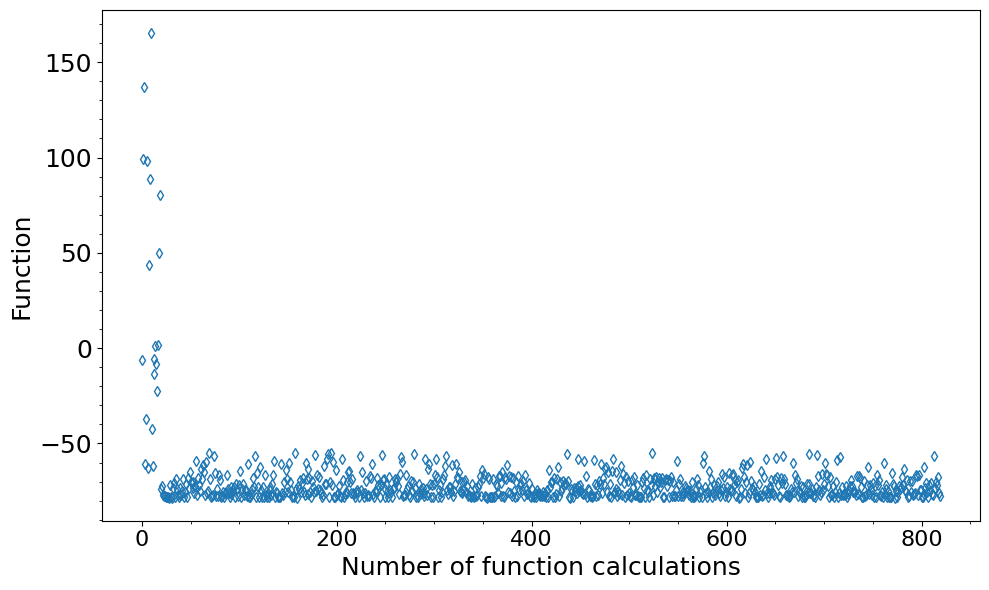

In [8]:
Info.icase = 14
Info.ndim = 2
Info.lknn = False
Info.hassanat = False
Info.model12 = False
Info.beta = 2.
Info.niterations = Info.ndim * 400
Info.nsamples0 = 20
# np.random.seed(17)
if Info.icase == 14:
    lw = [-5.] * Info.ndim
    up = [5.] * Info.ndim
if Info.icase == 12:
    lw = [-5.12] * Info.ndim
    up = [5.12] * Info.ndim
if Info.icase == 11:
    lw = [-600.]*Info.ndim
    up = [600.]*Info.ndim
Info.lw = lw
Info.up = up
driverBOKNN(lw, up)